Задание

Цель исследования — проанализировать набор данных о бронировании рейсов, полученный с веб-сайта «Ease My Trip». «Easemytrip» — это интернет-платформа для бронирования авиабилетов и, следовательно, платформа, которую потенциальные пассажиры используют для покупки билетов. Тщательное изучение данных поможет найти ценную информацию, которая будет иметь огромное значение для пассажиров.

Вам необходимо:

Исследовать данные (пропуски, дубликаты и т.д.).  

Узнать, изменяется ли стоимость перелёта в зависимости от авиакомпании?  

Исследовать зависимость средней цены от количества дней до полёта.

Исследовать зависимость средней цены полёта от его продолжительности.

Узнать, как меняется цена при изменении города вылета и пункта назначения? 
(Не забывайте писать небольшие выводы по итогам пунктов в EDA)

С помощью инструментов машинного обучения предсказать стоимость перелёта.

Провести сравнения обученных моделей, выбрать наилучшую (не забывайте про возможность переобучения моделей, разница между значением на трейне и тесте не должна превышать 150–200 единиц).   
(Для выполнения задания необходимо получить RMSE не ниже 3350 на тестовой выборке. Также можете воспользоваться GradientBoosting и попробовать получить метрику ниже 2750)

Напишите вывод о проделанной работе, опишите EDA и результат обучения моделей.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix
from phik import report
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)

In [2]:
# Загрузка данных
df = pd.read_csv('data/Airlines.csv')

In [3]:
df.head(3)

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956


- Столбец *Unnamed: 0* не нужен.
- Столбец *class* назван зарезервированным словом, его лучше переименовать.

In [4]:
#Удалю ненужный столбец *Unnamed: 0*
df.drop('Unnamed: 0', axis = 1, inplace = True) 
#Переименовываю столбец
df.rename(columns = {'class' : 'service_class'}, inplace = True)

In [5]:
#Проверяю типы данных и пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   service_class     300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [6]:
#Статитстическая информация
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
airline,300153,6,Vistara,127859,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flight,300153,1561,UK-706,3235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source_city,300153,6,Delhi,61343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
departure_time,300153,6,Morning,71146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stops,300153,3,one,250863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_time,300153,6,Night,91538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
destination_city,300153,6,Mumbai,59097,NaN,NaN,NaN,NaN,NaN,NaN,NaN
service_class,300153,2,Economy,206666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,300153.0,NaN,NaN,NaN,12.221021,7.191997,0.83,6.83,11.25,16.17,49.83
days_left,300153.0,NaN,NaN,NaN,26.004751,13.561004,1.0,15.0,26.0,38.0,49.0


In [7]:
# Проверка на дубликаты
print(f'В датасете {len(df) - len(df.drop_duplicates())} дубликатов строк')

В датасете 0 дубликатов строк


Посмотрю рейсы

In [8]:
df[df.flight == 'I5-764']

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,service_class,duration,days_left,price
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
141,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,2,5956
265,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,3,5956
450,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,4,6139
623,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,5,6139
...,...,...,...,...,...,...,...,...,...,...,...
19058,AirAsia,I5-764,Delhi,Early_Morning,one,Afternoon,Bangalore,Economy,10.33,45,3090
19288,AirAsia,I5-764,Delhi,Early_Morning,one,Afternoon,Bangalore,Economy,10.33,46,3090
19504,AirAsia,I5-764,Delhi,Early_Morning,one,Afternoon,Bangalore,Economy,10.33,47,3090
19724,AirAsia,I5-764,Delhi,Early_Morning,one,Afternoon,Bangalore,Economy,10.33,48,3090


In [9]:
df[df.flight == 'SG-8709']

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,service_class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
274,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,3,6060
398,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,4,5953
564,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,5,5953
739,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,6,5953
...,...,...,...,...,...,...,...,...,...,...,...
42049,SpiceJet,SG-8709,Delhi,Evening,one,Early_Morning,Chennai,Economy,13.08,43,4942
42053,SpiceJet,SG-8709,Delhi,Evening,one,Night,Chennai,Economy,26.42,43,4942
42228,SpiceJet,SG-8709,Delhi,Evening,one,Night,Chennai,Economy,26.83,44,4942
42381,SpiceJet,SG-8709,Delhi,Evening,one,Night,Chennai,Economy,27.00,45,4942


Меня смущает, что один и тот же рейс летает в разные города. На сколько мне известно такого быть не должно.

Посмотрю какие значения могут принимать категориальные данные в столбцах

In [10]:
airline_ = df.airline.unique().tolist()
airline_

['SpiceJet', 'AirAsia', 'Vistara', 'GO_FIRST', 'Indigo', 'Air_India']

In [11]:
source_city_ = df.source_city.unique().tolist()
source_city_

['Delhi', 'Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai']

In [12]:
destination_city_ = df.destination_city.unique().tolist()
destination_city_

['Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai', 'Delhi']

In [13]:
departure_time_ = df.departure_time.unique().tolist()
departure_time_


['Evening', 'Early_Morning', 'Morning', 'Afternoon', 'Night', 'Late_Night']

In [14]:
arrival_time_ = df.arrival_time.unique().tolist()
arrival_time_

['Night', 'Morning', 'Early_Morning', 'Afternoon', 'Evening', 'Late_Night']

In [15]:
stops_ = df.stops.unique().tolist()
stops_

['zero', 'one', 'two_or_more']

In [16]:
service_class_ = df['service_class'].unique().tolist()
service_class_

['Economy', 'Business']

Посмотрю корреляцию между праметрами

interval columns not set, guessing: ['duration', 'days_left', 'price']


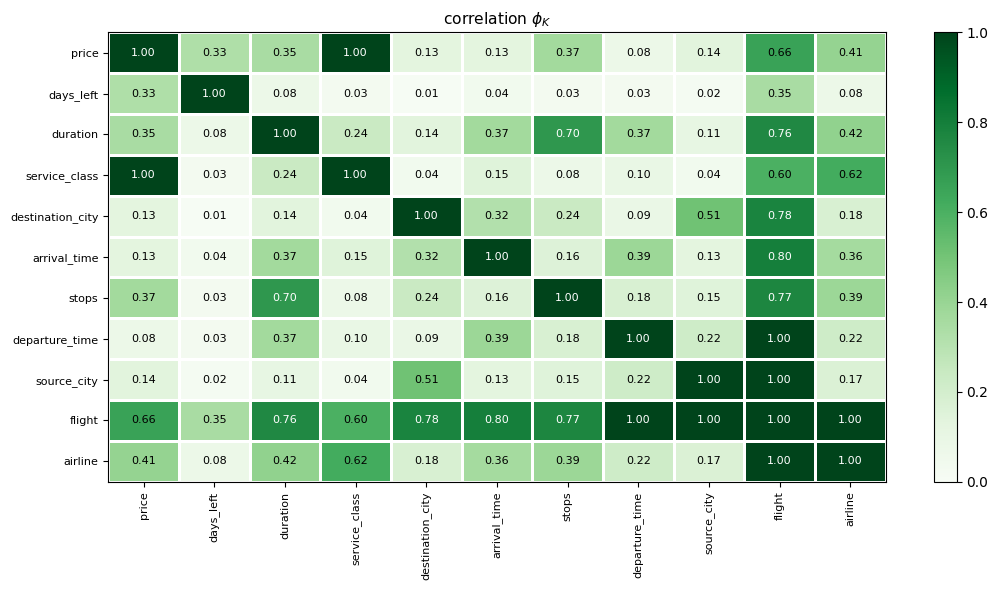

In [17]:
phik_overview = df.phik_matrix().round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6));

Меня опять смущает столбец *flight*. По идее он должен иметь 100%-ную корреляцию с *duration*, *destination_city*, *stops*, но этого не наблюдается.

100%-ное влияние класса обслуживание на стоимость полета вполне логична.

Узнаю как меняется цена в зависимости от класса обслуживания

Среднняя цена класса "Эконом" = 6572.34 
Среднняя цена класса "Бизнес" = 52540.08


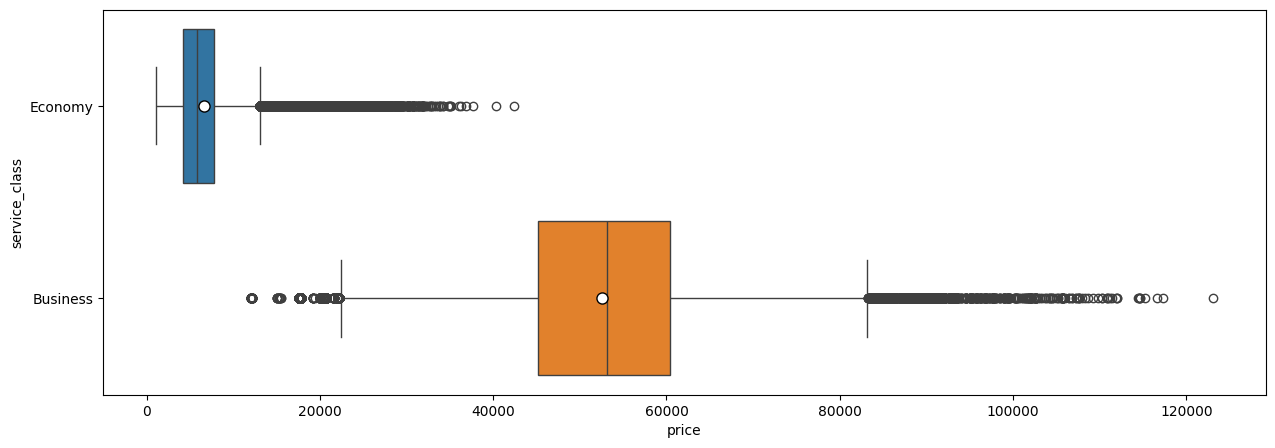

In [18]:
a = df.groupby(by = 'service_class').price.mean()
print(f'Среднняя цена класса "Эконом" = {round(a[1], 2)} \nСреднняя цена класса "Бизнес" = {round(a[0], 2)}')
fig, ax =  plt.subplots(1, 1, figsize = [15, 5]) 
sns.boxplot(x='price', y='service_class', data = df, orient='h', showmeans=True, hue='service_class',  
            meanprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize': '8'});

Средняя цена бизнес класса значительно превышает цену эконом

Узнаю как зависист цена от количесва пересадок

Среднняя цена без пресадок = 9375.94 
Среднняя цена с одной пересадкой = 22900.99       
Среднняя цена с несколькими пересадками = 14113.45


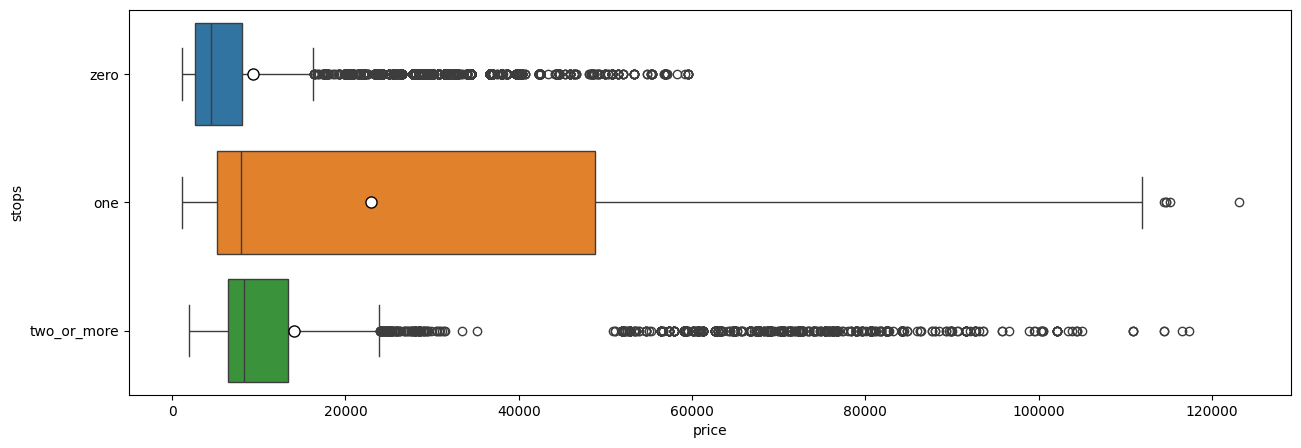

In [19]:
a = df.groupby(by = 'stops').price.mean()
print(f'Среднняя цена без пресадок = {round(a[2], 2)} \nСреднняя цена с одной пересадкой = {round(a[0], 2)} \
      \nСреднняя цена с несколькими пересадками = {round(a[1], 2)}')
fig, ax =  plt.subplots(1, 1, figsize = [15, 5]) 
sns.boxplot(x='price', y='stops', data = df, orient='h', showmeans=True, hue='stops',  
            meanprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize': '8'});

Средняя цена перелета с одной пересадкой более высокая, в то же время наблюдаются выбросы с высокой ценой перелета без пересадок и перелета с большим числом пересадок

Узнаю, как меняется цена при изменении города вылета и пункта назначения? 

In [20]:
df.groupby(by = ['source_city', 'destination_city']).price.mean()

source_city  destination_city
Bangalore    Chennai             23321.850078
             Delhi               17723.313972
             Hyderabad           21226.121192
             Kolkata             23500.061229
             Mumbai              23128.618672
Chennai      Bangalore           25081.850454
             Delhi               18981.863948
             Hyderabad           21591.345404
             Kolkata             22669.932407
             Mumbai              22765.849647
Delhi        Bangalore           17880.216315
             Chennai             19369.881354
             Hyderabad           17347.288379
             Kolkata             20566.409418
             Mumbai              19355.829812
Hyderabad    Bangalore           21347.177998
             Chennai             21848.065989
             Delhi               17243.945685
             Kolkata             20823.893201
             Mumbai              20080.865759
Kolkata      Bangalore           22744.808428
    

Средняя цена незначительно ниже, если город вылета или прилета Delhi, в остальном явной закономерности я не наблюдаю

Узнать, изменяется ли стоимость перелёта в зависимости от авиакомпании? 

Среднняя цена авиакомпании AirAsia = 4091.07       
Среднняя цена авиакомпании Air_India = 23507.02       
Среднняя цена авиакомпании GO_FIRST = 5652.01       
Среднняя цена авиакомпании Indigo = 5324.22       
Среднняя цена авиакомпании SpiceJet = 6179.28       
Среднняя цена авиакомпании Vistara = 30396.54


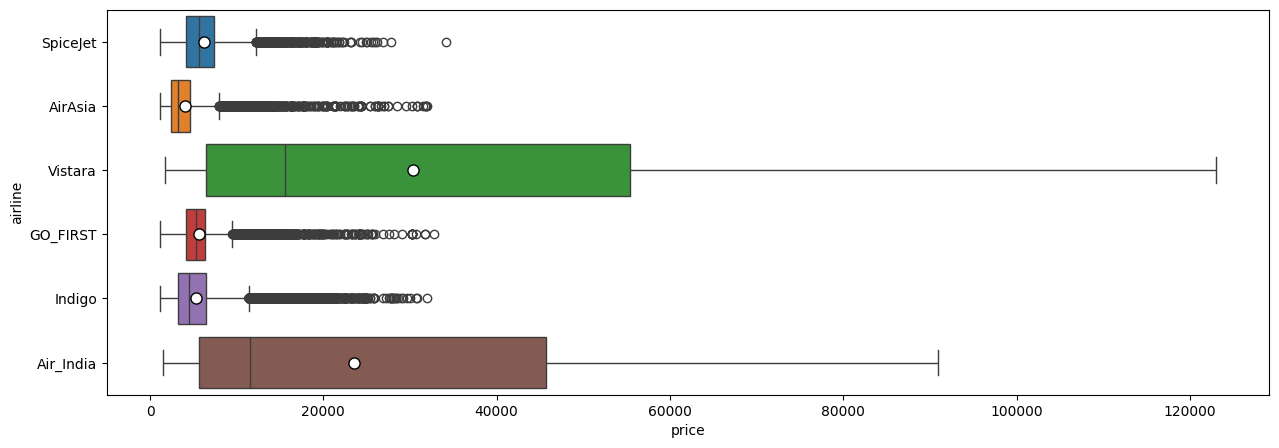

In [22]:
a = df.groupby(by = 'airline').price.mean()
print(f'Среднняя цена авиакомпании {a.index[0]} = {round(a.values[0], 2)} \
      \nСреднняя цена авиакомпании {a.index[1]} = {round(a.values[1], 2)} \
      \nСреднняя цена авиакомпании {a.index[2]} = {round(a.values[2], 2)} \
      \nСреднняя цена авиакомпании {a.index[3]} = {round(a.values[3], 2)} \
      \nСреднняя цена авиакомпании {a.index[4]} = {round(a.values[4], 2)} \
      \nСреднняя цена авиакомпании {a.index[5]} = {round(a.values[5], 2)}')
fig, ax =  plt.subplots(1, 1, figsize = [15, 5]) 
sns.boxplot(x='price', y='airline', data = df, orient='h', showmeans=True, hue='airline',  
            meanprops={'marker': 'o', 'markerfacecolor': 'white', 'markeredgecolor': 'black', 'markersize': '8'});

Цена перелета авиакомпаниями Vistara и Air_India значительно выше. Почему так? Посмотрю какие классы обслуживания предлагаю авиакомпании

In [23]:
df.groupby(by = ['airline', 'service_class']).price.mean()

airline    service_class
AirAsia    Economy           4091.072742
Air_India  Business         47131.039212
           Economy           7313.682169
GO_FIRST   Economy           5652.007595
Indigo     Economy           5324.216303
SpiceJet   Economy           6179.278881
Vistara    Business         55477.027777
           Economy           7806.943645
Name: price, dtype: float64

Как можно видеть из структуры классов обслуживания авиакомпаний, высокая средняя цена у Vistara и Air_India связана с тем, что они предлагают бизнес классс

Исследую зависимость средней цены от количества дней до полёта.

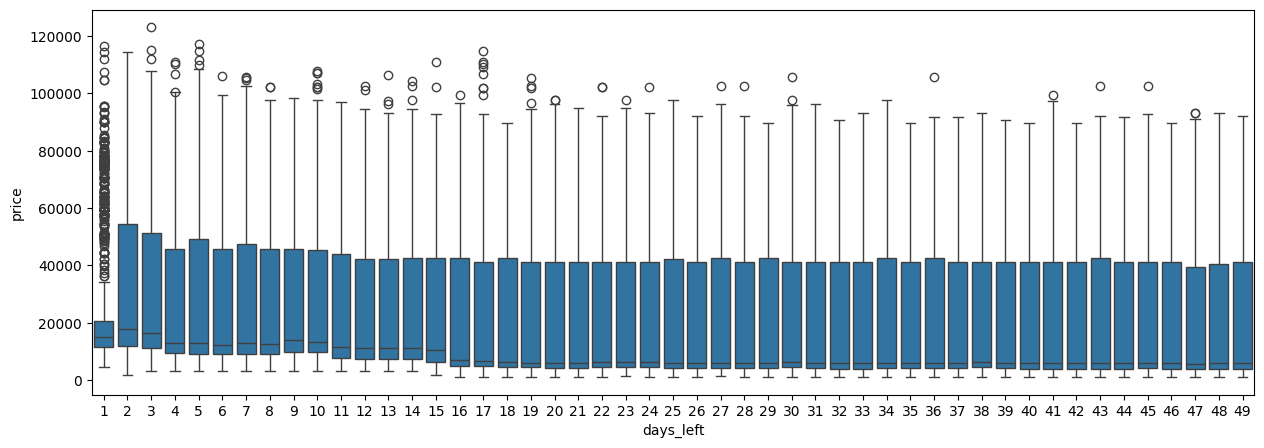

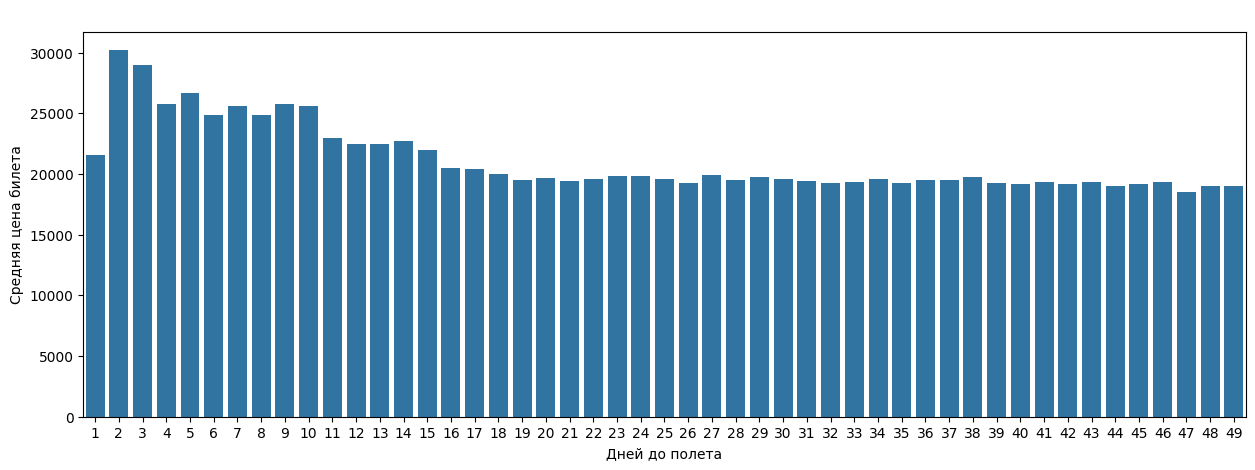

In [27]:
fig, ax =  plt.subplots(1, 1, figsize = [15, 5]) 
sns.boxplot(y='price', x='days_left', data = df)

df_left_price = df.groupby(by = 'days_left').price.mean()
fig, ax =  plt.subplots(1, 1, figsize = [15, 5]) 
sns.barplot(x= df_left_price.index, y= df_left_price.values)

ax.set_title(' ')
ax.set_ylabel('Средняя цена билета')
ax.set_xlabel('Дней до полета')
plt.show();

Средняя цена незначительно растет по мере приближения даты полета, а за тем падает за 1 день до полета, в тоже время цена за 1 день до полета имеет большое количестов выбросов

Исследование зависимости средней цены полёта от его продолжительности

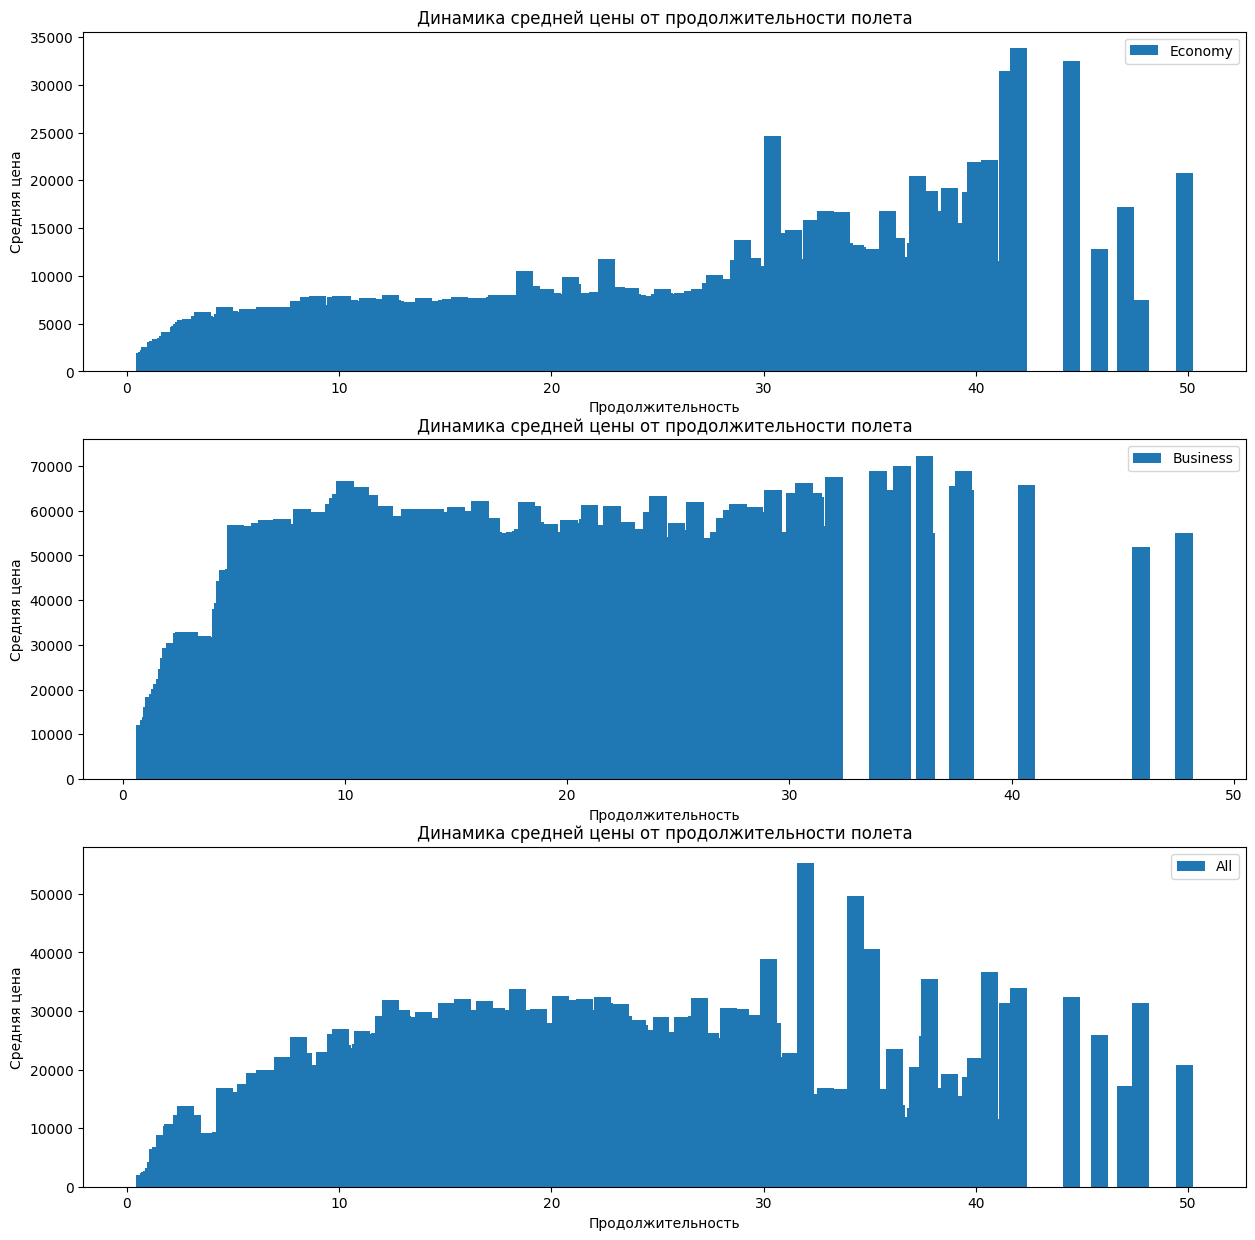

In [26]:
df_dur_price = df.groupby(by = 'duration').price.mean()
df_econom = df[(df.service_class  == 'Economy')]
df_business = df[(df.service_class == 'Business')]

mean_price_econom = df_econom.groupby(by = 'duration').price.mean()
mean_price_business = df_business.groupby(by = 'duration').price.mean()

fig, ax =  plt.subplots(3, 1, figsize = [15, 15]) 

ax[0].bar(x = mean_price_econom.index, height = mean_price_econom.values, label = 'Economy')
ax[0].set_title('Динамика средней цены от продолжительности полета')
ax[0].set_ylabel('Средняя цена')
ax[0].set_xlabel('Продолжительность')

ax[1].bar(x = mean_price_business.index, height = mean_price_business.values, label = 'Business')
ax[1].set_title('Динамика средней цены от продолжительности полета')
ax[1].set_ylabel('Средняя цена')
ax[1].set_xlabel('Продолжительность')

ax[2].bar(x = df_dur_price.index, height = df_dur_price.values, label = 'All')
ax[2].set_title('Динамика средней цены от продолжительности полета')
ax[2].set_ylabel('Средняя цена')
ax[2].set_xlabel('Продолжительность')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.show();

Средняя цена растет с увеличением продолжительности полета, но не прямопропорционально.

## Выводы по EDA



Набор данных содержит информацию о бронировании авиабилетов 6-ти авиакомпаний между 6 городами

Одному номеру рейса может соответствовать разный маршрут (по информации найденой в интеренет такое возможно)

Наибольшее влияние на цену билета оказывает класс обслуживания. Так же на цену влияет количество дней до вылета, продолжительность полета, число пересадок, авиакомпания. Остальные параметры оказывают минимальное влияние



## Построение моделей и обучение

Преобразую категориальные переменные в числа

In [28]:
cat_columns = df.select_dtypes(['object']).columns

#convert all categorical columns to numeric
df[cat_columns] = df[cat_columns].apply( lambda x: pd.factorize (x)[ 0 ])

In [29]:
df.head(5)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,service_class,duration,days_left,price
0,0,0,0,0,0,0,0,0,2.17,1,5953
1,0,1,0,1,0,1,0,0,2.33,1,5953
2,1,2,0,1,0,2,0,0,2.17,1,5956
3,2,3,0,2,0,3,0,0,2.25,1,5955
4,2,4,0,2,0,1,0,0,2.33,1,5955


СТРОЮ МОДЕЛЬ

In [30]:
features = df.drop(['price'], axis=1)
target = df['price']

print(features.shape)
print(target.shape)

(300153, 10)
(300153,)


In [32]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

In [33]:
#Решающее дерево
dtr = DecisionTreeRegressor()
dtr.fit(features_train, target_train)

DecisionTreeRegressor()

In [34]:
pred_dtr = dtr.predict(features_test)
pred_dtr_train = dtr.predict(features_train)
rmse_dtr = mean_squared_error(target_test, pred_dtr) ** 0.5
rmse_dtr_train = mean_squared_error(target_train, pred_dtr_train) ** 0.5
r2_dtr = r2_score(target_test, pred_dtr)
r2_dtr_train = r2_score(target_train, pred_dtr_train) 
print(f'RMSE тестовой выборки = {rmse_dtr}')
print(f'RMSE обучающей выборки = {rmse_dtr_train}')
print(f'R2 тестовой выборки = {r2_dtr}')
print(f'R2 обучающей выборки = {r2_dtr_train}')
print(f'Глубина дерева = {dtr.get_depth()}')


RMSE тестовой выборки = 2997.2012843785237
RMSE обучающей выборки = 229.63627193448048
R2 тестовой выборки = 0.982573182435768
R2 обучающей выборки = 0.9998976286585489
Глубина дерева = 39


Модель с параметрами по умолчаю переобучена

Посмотрю какие параметры влияют на результат

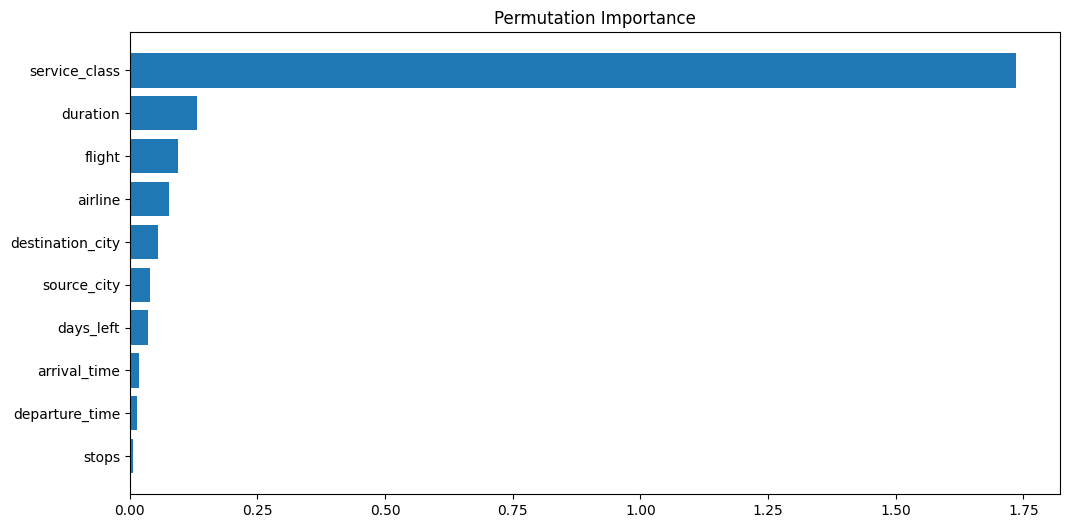

In [35]:
perm_importance = permutation_importance(dtr, features_test, target_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features.columns)[sorted_idx])
plt.title('Permutation Importance');

Как и было замечено на EDA, наибольшее влияние на цену оказывает класс обслуживания, далее идут - продолжительность, рейс, авиакомпания

In [36]:
#Линейная регрессия
lr = LinearRegression()
lr.fit(features_train, target_train)

LinearRegression()

In [37]:
pred_lr = lr.predict(features_test)
pred_lr_train = lr.predict(features_train)
rmse_lr = mean_squared_error(target_test, pred_lr) ** 0.5
rmse_lr_train = mean_squared_error(target_train, pred_lr_train) ** 0.5
r2_lr = r2_score(target_test, pred_lr)
r2_lr_train = r2_score(target_train, pred_lr_train) 
print(f'RMSE тестовой выборки = {rmse_lr}')
print(f'RMSE обучающей выборки = {rmse_lr_train}')
print(f'R2 тестовой выборки = {r2_lr}')
print(f'R2 обучающей выборки = {r2_lr_train}')


RMSE тестовой выборки = 7053.1421521265875
RMSE обучающей выборки = 7047.126598582042
R2 тестовой выборки = 0.9034946170433962
R2 обучающей выборки = 0.9035901147574046


Модель выдает слишком большую RMSE

Посмотрю какие параметры влияют на результат

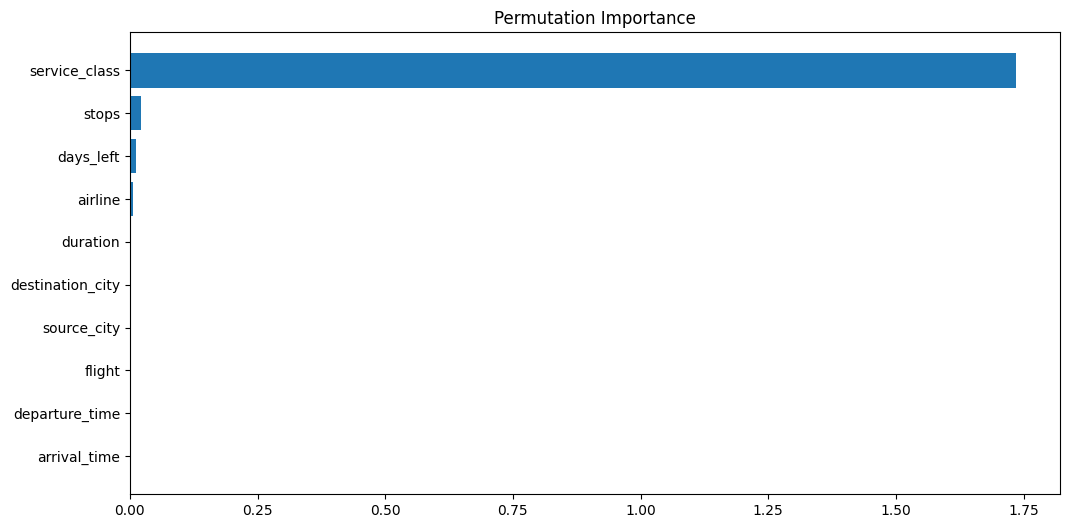

In [38]:
perm_importance = permutation_importance(lr, features_test, target_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features.columns)[sorted_idx])
plt.title('Permutation Importance');

Линейная регрессия учитывает только класс обслуживания

In [39]:
#Случайный лес
rfr = RandomForestRegressor()
rfr.fit(features_train, target_train)

RandomForestRegressor()

In [40]:
pred_rfr = rfr.predict(features_test)
pred_rfr_train = rfr.predict(features_train)
rmse_rfr = mean_squared_error(target_test, pred_rfr) ** 0.5
rmse_rfr_train = mean_squared_error(target_train, pred_rfr_train) ** 0.5
r2_rfr = r2_score(target_test, pred_rfr)
r2_rfr_train = r2_score(target_train, pred_rfr_train) 
print(f'RMSE тестовой выборки = {rmse_rfr}')
print(f'RMSE обучающей выборки = {rmse_rfr_train}')
print(f'R2 тестовой выборки = {r2_rfr}')
print(f'R2 обучающей выборки = {r2_rfr_train}')

RMSE тестовой выборки = 2369.9390064876675
RMSE обучающей выборки = 895.3502256435119
R2 тестовой выборки = 0.9891041628733692
R2 обучающей выборки = 0.9984437358479795


Модель перобучена

Посмотрю какие параметры влияют на результат

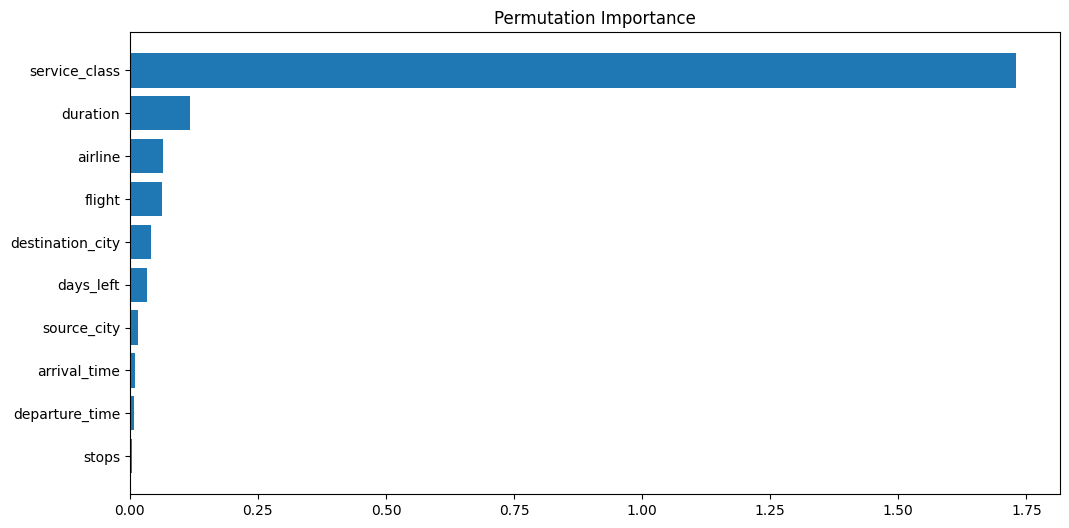

In [41]:
perm_importance = permutation_importance(rfr, features_test, target_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features.columns)[sorted_idx])
plt.title('Permutation Importance');

Как и было замечено на EDA, наибольшее влияние на цену оказывает класс обслуживания, далее идут - продолжительность, авиакомпания, рейс

#### Улучшение моделей

Методом подбора глубины я смог получить значения указанные в задании при глубине 12

In [42]:
dtr = DecisionTreeRegressor(max_depth = 12)
dtr.fit(features_train, target_train)

DecisionTreeRegressor(max_depth=12)

In [43]:
pred_dtr = dtr.predict(features_test)
pred_dtr_train = dtr.predict(features_train)
rmse_dtr = mean_squared_error(target_test, pred_dtr) ** 0.5
rmse_dtr_train = mean_squared_error(target_train, pred_dtr_train) ** 0.5
r2_dtr = r2_score(target_test, pred_dtr)
r2_dtr_train = r2_score(target_train, pred_dtr_train) 
print(f'RMSE тестовой выборки = {rmse_dtr}')
print(f'RMSE обучающей выборки = {rmse_dtr_train}')
print(f'R2 тестовой выборки = {r2_dtr}')
print(f'R2 обучающей выборки = {r2_dtr_train}')

RMSE тестовой выборки = 3833.8082576122342
RMSE обучающей выборки = 3627.215472539604
R2 тестовой выборки = 0.9714867290113092
R2 обучающей выборки = 0.9744586334575558


In [44]:
rfr = RandomForestRegressor(max_depth = 12)
rfr.fit(features_train, target_train)


RandomForestRegressor(max_depth=12)

In [45]:
pred_rfr = rfr.predict(features_test)
pred_rfr_train = rfr.predict(features_train)
rmse_rfr = mean_squared_error(target_test, pred_rfr) ** 0.5
rmse_rfr_train = mean_squared_error(target_train, pred_rfr_train) ** 0.5
r2_rfr = r2_score(target_test, pred_rfr)
r2_rfr_train = r2_score(target_train, pred_rfr_train) 
print(f'RMSE тестовой выборки = {rmse_rfr}')
print(f'RMSE обучающей выборки = {rmse_rfr_train}')
print(f'R2 тестовой выборки = {r2_rfr}')
print(f'R2 обучающей выборки = {r2_rfr_train}')

RMSE тестовой выборки = 3547.1356799361197
RMSE обучающей выборки = 3362.13620374408
R2 тестовой выборки = 0.9755914564340595
R2 обучающей выборки = 0.978055381996778


## Выводы по результатам обучения моделей

По результатам улучшения моделей, наилучший результат показала модель **RandomForestRegressor** при глубине *max_depth* = 12 RMSE тестовой выборки = 3547.1356799361197, RMSE обучающей выборки = 3362.13620374408

Линейная регрессия отработала некорректнее всего, учитывая практически только один параметр.